# Exploring the manual classification to determine features for modeling

In [1]:
import pandas as pd
import numpy as np
import math
import pickle
import os
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import tree
import psycopg2

%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from src import util
from src.visualization import scatter

/home/claas/gdeltsocialvideo/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


658 489 163



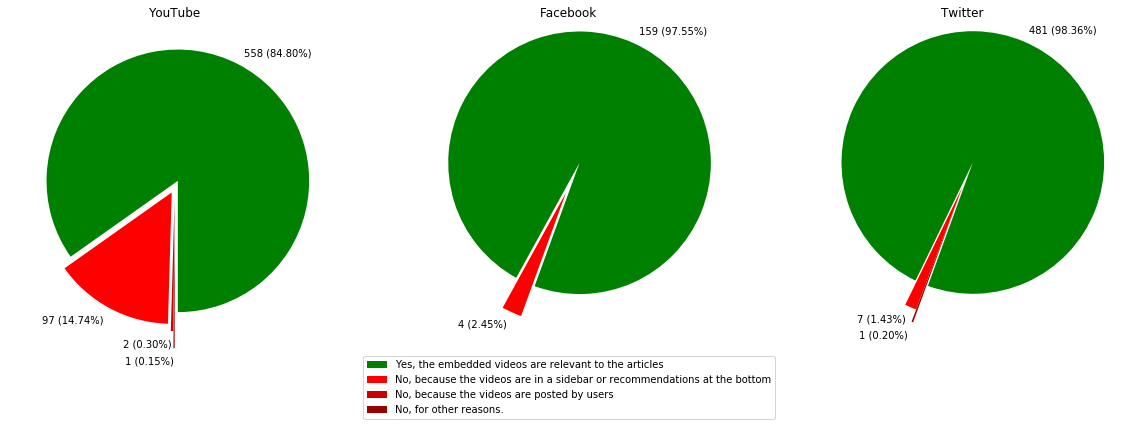

In [2]:
# select twitter_relevant, count(twitter_relevant) from labeled_sources WHERE twitter_relevant<>-1 group by twitter_relevant;
# Pie chart of the labels. All pie charts in one figure
labels = ["Yes, the embedded videos are relevant to the articles", 
          "No, because the videos are in a sidebar or recommendations at the bottom",
          "No, because the videos are posted by users",
          "No, for other reasons."]

youtube = [558, 97, 2, 1]
facebook = [159, 4]
twitter = [481, 7, 1]

print(sum(youtube),sum(twitter), sum(facebook))
f, axarr = plt.subplots(1,3,figsize=(20,10))
print()

patches, _ = axarr[0].pie(youtube, colors=['green', '#ff0000', '#cc0000','#990000'], 
             startangle=270,
             explode=[0.05,0.05,0.1,0.23],
             labels=["%d (%.2f%%)" % (value, value/sum(youtube)*100) for value in youtube])
axarr[0].set_title("YouTube")

axarr[1].pie(facebook, colors=['green', '#ff0000'],
             startangle=250,
             explode=[0.2,0.05],
             labels=["%d (%.2f%%)" % (value, value/sum(facebook)*100) for value in facebook])
axarr[1].set_title("Facebook")
lgd = axarr[1].legend(patches, labels, bbox_to_anchor=(0.5,0),loc="upper center")

axarr[2].pie(twitter, colors=['green', '#ff0000','#990000'],
             startangle=250,
             explode=[0.2,0, 0.1],
             labels=["%d (%.2f%%)" % (value, value/sum(twitter)*100) for value in twitter])

axarr[2].set_title("Twitter")
plt.savefig(os.environ['FIGURES_PATH'] + "labelpies.pdf", format="pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [3]:
# Load the dataset from the database 
conn = psycopg2.connect(database="gdelt_social_video", user="postgres")
c = conn.cursor()
# Just work with youtube for now
platform = "youtube"
query = '''SELECT s.article_count, s.source_name, s.youtube_std_dev, s.youtube_sum, s.youtube_count, s.youtube_sum_distinct, lh.youtube_relevant FROM sources s INNER JOIN labeled_sources lh  ON s.source_name=lh.source_name
                                WHERE lh.youtube_relevant <> -1 AND s.youtube_sum > 0'''
samples = pd.read_sql_query(query,con=conn)

#TODO remove the "video" from feature names. Put feature names in array.
samples = samples[["source_name",
                   "article_count", 
                   "%s_sum" % platform, 
                   "%s_sum_distinct" % platform, 
                   "%s_count" % platform, 
                   "%s_std_dev" % platform, 
                   "%s_relevant" % platform]]

# Compute the remaining interesting features
# Average number of videos per article, including articles without videos
samples["%s_average" % platform] = samples["%s_sum" % platform] / samples["article_count"]
# Average distinct videos per article
samples["%s_average_distinct" % platform] = samples["%s_sum_distinct" % platform] / samples["article_count"]
# Total videos to distinct videos
samples["%s_distinct_to_sum" % platform] = samples["%s_sum_distinct" % platform] / samples["%s_sum" % platform]
# Percentage of articles with videos
samples["%s_percentage" % platform] = samples["%s_count" % platform] / samples["article_count"]
# Binary relevance (used for classification)
samples["%s_relevant_binary" % platform] = samples["%s_relevant" % platform] == 1

samples.head()

,source_name,article_count,youtube_sum,youtube_sum_distinct,youtube_count,youtube_std_dev,youtube_relevant,youtube_average,youtube_average_distinct,youtube_distinct_to_sum,youtube_percentage,youtube_relevant_binary
0,watoday.com.au,408,3,3,2,0.500000,1,0.007353,0.007353,1.000000,0.004902,True
1,nagariknetwork.com,713,1,1,1,0.000000,1,0.001403,0.001403,1.000000,0.001403,True
2,kanw.com,400,39,38,20,1.160819,1,0.097500,0.095000,0.974359,0.050000,True
3,meduza.io,11,1,1,1,0.000000,1,0.090909,0.090909,1.000000,0.090909,True
4,musicconnection.com,15,15,2,15,0.000000,2,1.000000,0.133333,0.133333,1.000000,False


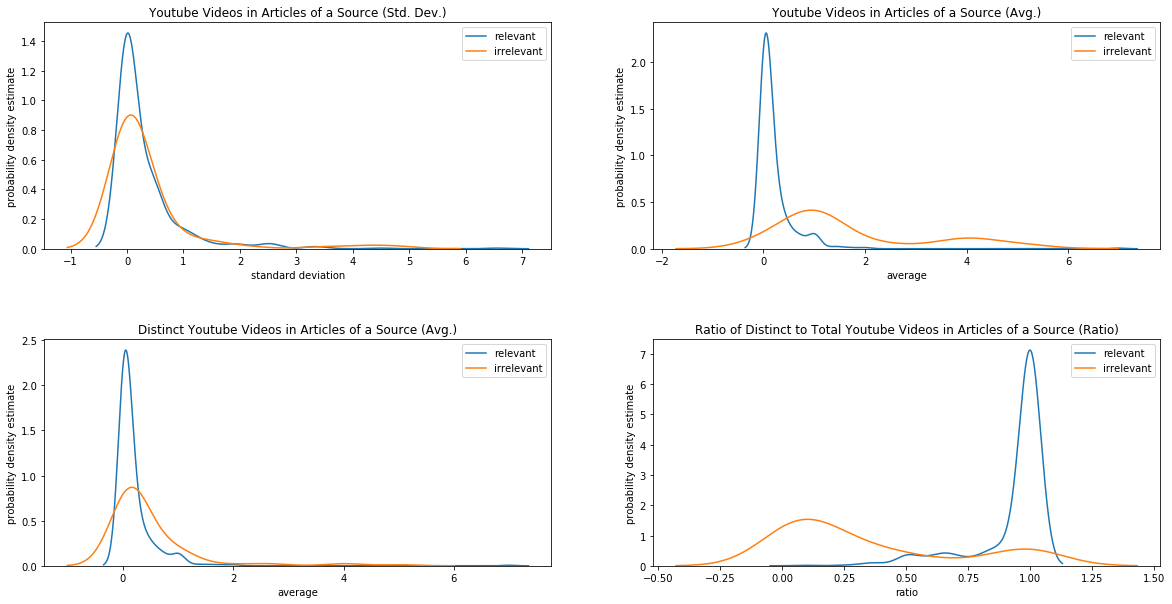

In [4]:
# Plot various interesting densitites
plot_feature_densities = ["youtube_std_dev",
                          "youtube_average",
                          "youtube_average_distinct",
                          "youtube_distinct_to_sum"]

titles = ["Youtube Videos in Articles of a Source (Std. Dev.)", 
          "Youtube Videos in Articles of a Source (Avg.)",
          "Distinct Youtube Videos in Articles of a Source (Avg.)",
          "Ratio of Distinct to Total Youtube Videos in Articles of a Source (Ratio)",
         ]
x_axis = ["standard deviation", "average", "average", "ratio"]
f, axarr = plt.subplots(2, 2, figsize=(20, 10))
axarr = np.ndarray.flatten(axarr)

relevant_samples = samples[samples["%s_relevant" % platform] == 1]
irrelevant_samples = samples[samples["%s_relevant" % platform] != 1]
for index, feature in enumerate(plot_feature_densities):
    ax = axarr[index]
    sns.kdeplot(data=relevant_samples[feature], ax=ax, label="relevant", gridsize=2000)
    sns.kdeplot(data=irrelevant_samples[feature], ax=ax, label="irrelevant", gridsize=2000)
    ax.set_xlabel(x_axis[index])
    ax.set_ylabel('probability density estimate')
    ax.set_title(titles[index])

#plt.suptitle('Density distributions of features by relevance'); 
plt.subplots_adjust(hspace=0.4)
plt.savefig(os.environ['FIGURES_PATH'] + "feature_densities.pdf", format="pdf", bbox_inches='tight')

In [5]:
len(samples)

651

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


train_on = ["youtube_average", "youtube_distinct_to_sum"] #, "youtube_video_average", "youtube_video_sum"

models = [svm.SVC(kernel='linear', C=100),# Higher C: Avoid misclassification (vs. optimize distance)
          svm.SVC(kernel='rbf', gamma=.5, C=100, probability=True), # Higher gamma; more clusters
          KNeighborsClassifier(7), # Maybe plot over k
          KNeighborsClassifier(8),
          KNeighborsClassifier(9),
          KNeighborsClassifier(10),
          KNeighborsClassifier(11),
          DecisionTreeClassifier()]

X_train, X_test, y_train, y_test = train_test_split(samples[train_on], samples['%s_relevant_binary' % platform], test_size=0.2)
for model in models:
    model.fit(samples[train_on], samples['%s_relevant_binary' % platform])
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    print(model.score(X_test, y_test))

Accuracy: 0.958 (+/- 0.026)
0.9618320610687023
Accuracy: 0.950 (+/- 0.031)
0.9618320610687023
Accuracy: 0.958 (+/- 0.029)
0.9618320610687023
Accuracy: 0.958 (+/- 0.029)
0.9618320610687023
Accuracy: 0.958 (+/- 0.029)
0.9618320610687023
Accuracy: 0.958 (+/- 0.029)
0.9618320610687023
Accuracy: 0.958 (+/- 0.029)
0.9618320610687023
Accuracy: 0.927 (+/- 0.025)
0.9770992366412213


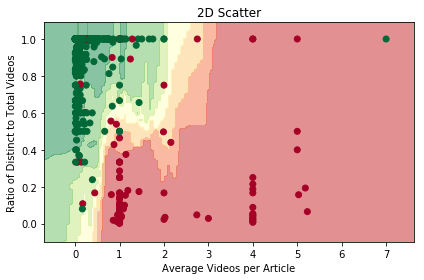

In [7]:
ax = plt.subplot()
scatter.scatter_2D(ax, 
                   samples['youtube_average'], 
                   samples['youtube_distinct_to_sum'], 
                   samples['youtube_relevant_binary'],
                   x_label="Average Videos per Article",
                   y_label="Ratio of Distinct to Total Videos",
                   clf=models[4])
plt.tight_layout()
plt.savefig(os.environ['FIGURES_PATH'] + "source_classifier.pdf", format="pdf")
plt.show()

In [11]:
from sklearn.metrics import roc_curve

classifier = models[4]

x_test = list(zip(samples['youtube_average'], samples['youtube_distinct_to_sum']))
y_predict = [y for x,y in classifier.predict_proba(x_test)]
y_test = list(samples['youtube_relevant_binary'])

fpr, tpr, thresholds = roc_curve(y_test, y_predict)
print(fpr)
print(tpr)
print(thresholds)

[0.         0.         0.1010101  0.2020202  0.21212121 0.23232323
 0.25252525 0.29292929 0.31313131 0.33333333 1.        ]
[0.         0.76811594 0.92391304 0.98007246 0.98731884 0.99456522
 0.99456522 0.99818841 0.99818841 1.         1.        ]
[2.         1.         0.88888889 0.77777778 0.66666667 0.55555556
 0.44444444 0.33333333 0.22222222 0.11111111 0.        ]


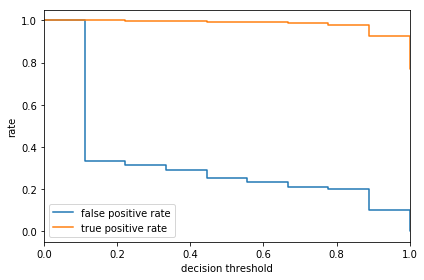

In [13]:
plt.step(thresholds, fpr) # blue
plt.step(thresholds, tpr) # orange
plt.legend(["false positive rate", "true positive rate"])
plt.xlabel("decision threshold")
plt.ylabel("rate")
plt.xlim(0,1)
plt.savefig(os.environ['FIGURES_PATH'] + "precision_recall_curve.pdf", format="pdf")
plt.tight_layout()
plt.show()